<a href="https://colab.research.google.com/github/JangHanjun/Hanryang_Win_Formula/blob/main/PoongWinPercent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
import urllib.request

from konlpy.tag import Okt
from konlpy.tag import Mecab
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 로드하기

In [35]:
chat_log = pd.read_csv('https://raw.githubusercontent.com/JangHanjun/Hanryang_Win_Formula/main/ChatLog.csv')
# csv file : https://github.com/JangHanjun/Hanryang_Win_Formula/blob/main/ChatLog.csv

train_data = chat_log[:6000]
test_data = chat_log[6000:]

train_data.head()

,TEXT,LABEL
0,밟어,1
1,이게 말이돼,1
2,이거 저번에 했지않음,0
3,대혼돈의 풍토토다,1
4,풍월량 믿고 마리오 골랐다구,1


   LABEL  count
0      0   3485
1      1   2515


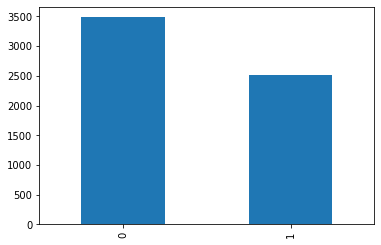

In [36]:
train_data['LABEL'].value_counts().plot(kind = 'bar')
print(train_data.groupby('LABEL').size().reset_index(name = 'count'))

토큰화 하기

In [37]:
okt = Okt()
mecab = Mecab()

In [38]:
X_train = []
for sentence in tqdm(train_data['TEXT']):
    # three tokinizer
    # tokenized_sentence = okt.morphs(sentence, stem=True)
    tokenized_sentence = mecab.morphs(sentence)
    # tokenized_sentence = sentence.split()

    X_train.append(tokenized_sentence)

X_train[:5]

100%|██████████| 6000/6000 [00:00<00:00, 39021.38it/s]


[['밟', '어'],
 ['이게', '말', '이', '돼'],
 ['이거', '저번', '에', '했', '지', '않', '음'],
 ['대', '혼돈', '의', '풍토', '토다'],
 ['풍월', '량', '믿', '고', '마리오', '골랐', '다구']]

In [39]:
X_test = []
for sentence in tqdm(test_data['TEXT']):
    # tokenized_sentence = okt.morphs(sentence, stem=True)
    tokenized_sentence = mecab.morphs(sentence)
    # tokenized_sentence = sentence.split()
    X_test.append(tokenized_sentence)

100%|██████████| 1224/1224 [00:00<00:00, 34644.49it/s]


정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

In [41]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 단어 수: %s'%(threshold - 1, rare_cnt))
print("희귀 단어 비율:", (rare_cnt / total_cnt)*100)
print("희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합 크기 : 2469
등장 빈도가 1번 이하인 단어 수: 1277
희귀 단어 비율: 51.72134467395707
희귀 단어 등장 빈도 비율: 7.059538946320969


In [42]:
# 전체 단어 개수 중 빈도수 1이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1193


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

In [44]:
y_train = np.array(train_data['LABEL'])
y_test = np.array(test_data['LABEL'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

패딩

In [46]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))

최대 길이 : 69
평균 길이 : 2.870411473450572


In [47]:
max_len = 20
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### LSTM으로 분류

In [55]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 해당 블럭을 건너뛰고 아래 코드에서 바로 모델을 받을 수 있습니다!

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [59]:
# 역대 에포크중 가장 최고 정확도의 모델 load 입니다. 
!gdown https://drive.google.com/uc?id=18RgTL-B9tkUco9TYPGnM3w57kEpOx0rF

# 모델 다운로드
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/best_model.h5')


Downloading...
From: https://drive.google.com/uc?id=18RgTL-B9tkUco9TYPGnM3w57kEpOx0rF
To: /content/best_model.h5
100% 1.93M/1.93M [00:00<00:00, 161MB/s]


In [60]:
loaded_model = load_model('best_model.h5')
print("\n정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# split => 0.7574
# mecab => 0.8031
# okt => 0.7810

39/39 [==============================] - 1s 10ms/step - loss: 0.4439 - acc: 0.8031

정확도: 0.8031


In [71]:
def sentiment_predict(new_sentence):
  output = new_sentence
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  # new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = mecab.morphs(new_sentence)
  # new_sentence = new_sentence.split()

  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print(output + " : {:.2f}% 확률로 풍월량 우승!!".format(score * 100))
  else:
    print(output + " : {:.2f}% 확률로 이번마 낙마!!".format((1 - score) * 100))

In [73]:
print("실제 방송과 맞는 예측\n")
sentiment_predict('풍월량 우승')
sentiment_predict('3번마 탈락')
sentiment_predict('풍월량 개모태')
sentiment_predict('루')
sentiment_predict('정배 우승')
sentiment_predict('엄마 난 커서 풍월량이 될래요!')
sentiment_predict('ㄹㅇㅋㅋ')

print("\n실제 방송과 잘 맞지 않는 예측\n")
sentiment_predict('마리오 우승')
sentiment_predict('아니 제발 형')

실제 방송과 맞는 예측

풍월량 우승 : 97.94% 확률로 풍월량 우승!!
3번마 탈락 : 99.85% 확률로 이번마 낙마!!
풍월량 개모태 : 83.62% 확률로 이번마 낙마!!
루 : 94.69% 확률로 이번마 낙마!!
정배 우승 : 96.24% 확률로 풍월량 우승!!
엄마 난 커서 풍월량이 될래요! : 69.43% 확률로 풍월량 우승!!
ㄹㅇㅋㅋ : 71.52% 확률로 이번마 낙마!!

실제 방송과 잘 맞지 않는 예측

마리오 우승 : 89.78% 확률로 풍월량 우승!!
아니 제발 형 : 70.49% 확률로 풍월량 우승!!
